# Emotion Classification with GloVe and LSTM

## Imports

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

##Data Prep

In [2]:
train_df = pd.read_csv('../emotion_dataset/train.txt', sep=';', header=None, names=['text', 'label'])
val_df = pd.read_csv('../emotion_dataset/val.txt', sep=';', header=None, names=['text', 'label'])
test_df = pd.read_csv('../emotion_dataset/test.txt', sep=';', header=None, names=['text', 'label'])

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    
    text = re.sub(r'[^\w\s]', '', text)  # punctuations
    text = text.lower()  # lower case
    text = re.sub(r'\d+', '', text)  # numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Stopwords
    text = re.sub(r'\s+', ' ', text).strip()  # space
    
    return text

train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
label_to_int = {'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}

train_df['label'] = train_df['label'].map(label_to_int)
val_df['label'] = val_df['label'].map(label_to_int)
test_df['label'] = test_df['label'].map(label_to_int)

In [17]:
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['text'])

X_train = tokenizer.texts_to_sequences(train_df['text'])
X_val = tokenizer.texts_to_sequences(val_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])

max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [18]:
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

## Download GloVe Vectors

Use => https://nlp.stanford.edu/projects/glove/

OR 

Use=> !wget http://nlp.stanford.edu/data/glove.6B.zip  &&& !unzip glove.6B.zip

In [7]:
# glove_zip_path = "/content/drive/MyDrive/Colab Notebooks/glove.6B.zip"
# with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/glove')

In [6]:
glove_file_path = '../glove6B/glove.6B.200d.txt'

## Load GloVe Vectors and Create Embedding Matrix

In [7]:
def load_glove_embeddings(file_path):
    
    embeddings_index = {}
    
    with open(file_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            weights = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = weights
            
    return embeddings_index


embeddings_index = load_glove_embeddings(glove_file_path)

list(embeddings_index.items())[:10]

[('the',
  array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
          3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
          1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
         -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
          4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
          7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
          1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
         -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
         -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
          6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
         -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
          8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
          1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
          1.4379e-01, -1.2325

In [8]:
len(embeddings_index)

400000

In [9]:
len(next(iter(embeddings_index.values())))

200

In [10]:
#  For modeling, It is to load word embeddings into an embedding matrix.
# Because I shall use this matrix in the modeling process to represent words.
embedding_dim = 200

vocab_size = len(tokenizer.word_index) + 1 # The tokenizer object uses padding for index 0, so +1 is added.

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Modeling

In [11]:
model = Sequential([
        Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=False, name='embedding_layer'),
        LSTM(128),
        BatchNormalization(),
        Dropout(0.2),
        Dense(6, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)          │ ?                           │       3,013,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,013,000 (11.49 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,013,000 (11.49 MB)

In [19]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5049 - loss: 1.3999 - val_accuracy: 0.7855 - val_loss: 0.6530
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8211 - loss: 0.5075 - val_accuracy: 0.8925 - val_loss: 0.3113
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8928 - loss: 0.2923 - val_accuracy: 0.8815 - val_loss: 0.3380
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9212 - loss: 0.2152 - val_accuracy: 0.9045 - val_loss: 0.2623
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9378 - loss: 0.1621 - val_accuracy: 0.9115 - val_loss: 0.2750
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9505 - loss: 0.1325 - val_accuracy: 0.9180 - val_loss: 0.2288
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9586 - loss: 0.1123 - val_accuracy: 0.9175 - val_loss: 0.2206
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9605 - loss: 0.1030 - val_

In [20]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Val Loss: {val_loss}", f"Val Accuracy: {val_accuracy}")
print(f"Test Loss: {test_loss}", f"Test Accuracy: {test_accuracy}")

Val Loss: 0.22055621445178986 Val Accuracy: 0.9175000190734863
Test Loss: 0.2142678201198578 Test Accuracy: 0.921500027179718


## Model Performance

In [21]:
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = y_pred.argmax(axis=-1)

classification_rep = classification_report(y_test, y_pred_classes)
accuracy = accuracy_score(y_test, y_pred_classes)

print(accuracy)
print(classification_rep)

0.9215
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       695
           1       0.97      0.96      0.96       581
           2       0.91      0.96      0.93       275
           3       0.91      0.87      0.89       224
           4       0.76      0.87      0.81       159
           5       0.72      0.77      0.74        66

    accuracy                           0.92      2000
   macro avg       0.87      0.89      0.88      2000
weighted avg       0.92      0.92      0.92      2000



## Embedding Vectors Alteration

In [22]:
embedding_layer = model.get_layer(name='embedding_layer')

embedding_weights = embedding_layer.get_weights()[0]

word_index = tokenizer.word_index

index_word = {v: k for k, v in word_index.items()}

emotions = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise', 'happy', 'sad', 'angry', 'fear', 'disgust']

emotion_vectors = {emotion: embedding_weights[word_index[emotion]] for emotion in emotions}

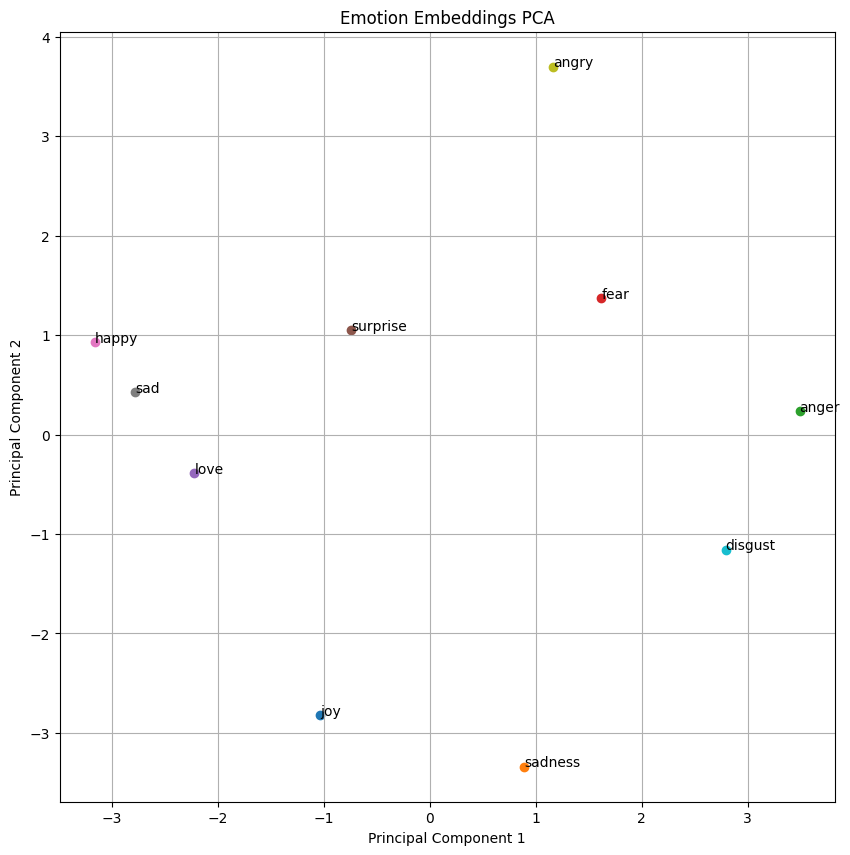

In [23]:
def plot_emotions(emotion_vectors):
    
    vectors = list(emotion_vectors.values())
    labels = list(emotion_vectors.keys())

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 10))
    for i, label in enumerate(labels):
        plt.scatter(pca_result[i, 0], pca_result[i, 1])
        plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]))
        
    plt.title('Emotion Embeddings PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()


plot_emotions(emotion_vectors)

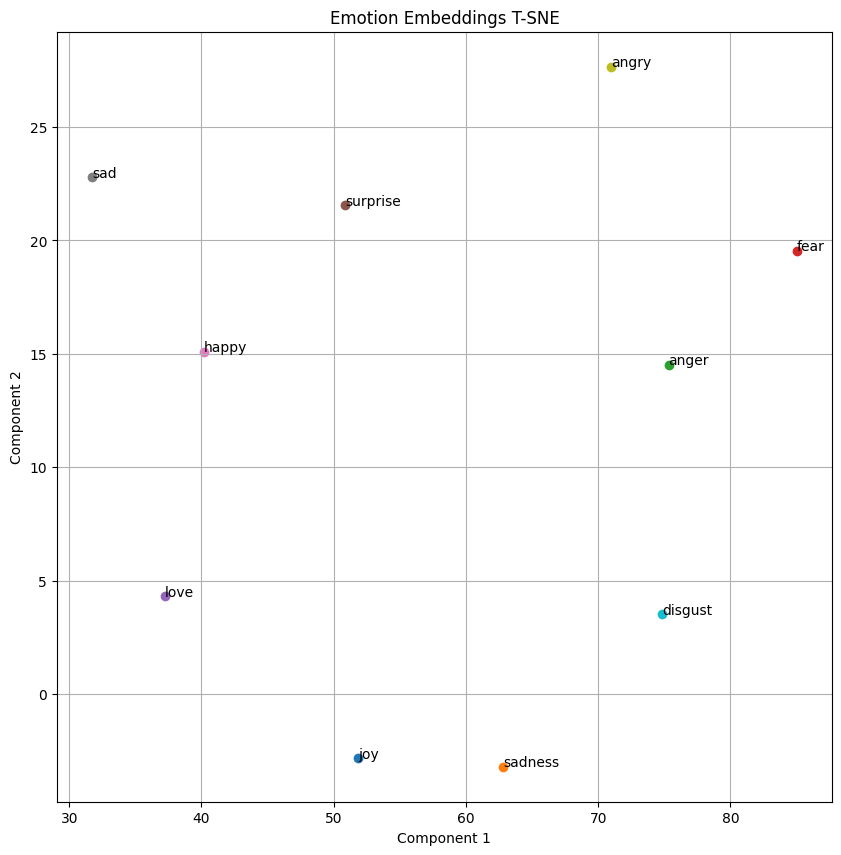

In [24]:
def plot_emotions_tsne(emotion_vectors):
    
    vectors = np.array(list(emotion_vectors.values()))
    labels = list(emotion_vectors.keys())

    tsne = TSNE(n_components=2, perplexity=5, random_state=0)
    tsne_result = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 10))
    for i, label in enumerate(labels):
        plt.scatter(tsne_result[i, 0], tsne_result[i, 1])
        plt.annotate(label, (tsne_result[i, 0], tsne_result[i, 1]))
        
    plt.title('Emotion Embeddings T-SNE')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()


plot_emotions_tsne(emotion_vectors)